## Imports

In [1]:
import pandas as pd
import numpy as np
import MDP as mdp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import kernel_ridge
from tqdm import tqdm
import copy

## Read Data

In [2]:
X_data = pd.read_csv('./data/X_data.csv')
X_data = np.array(X_data.values.tolist())
X_data = X_data[:,3]
X_data = X_data.reshape((84,720))

Y_data = pd.read_csv('./data/Y_data.csv')
Y_data = np.array(Y_data.values.tolist())
Y_data = Y_data[:,1]
Y_data = Y_data.reshape((84,720))

block_names = pd.read_csv('./data/block_names.csv')
block_names = np.array(block_names['0'].tolist())

## Split Training/Test Data

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=1/7, random_state=10)
print('Training Data Size:', len(x_train))
print('Testing Data Size:', len(x_test))

Training Data Size: 72
Testing Data Size: 12


## Clustering Blocks

In [72]:
n_clusters = 6
kmeans = KMeans(n_clusters, n_init='auto', random_state=73)
kmeans.fit(x_train)
clusters = kmeans.predict(x_train)

In [73]:
x_bins = [[] for i in range(n_clusters)]
y_bins = [[] for i in range(n_clusters)]
label_bins = [[] for i in range(n_clusters)]

for i, cluster in enumerate(clusters):
    x_bins[cluster].append(x_train[i])
    y_bins[cluster].append(y_train[i])
    label_bins[cluster].append(block_names[i])


In [74]:
# To visualize the data use PCA to reduce dimension to 2 and plot scatter plot
pca_2d = PCA(n_components=2)
PCA_2d = pca_2d.fit_transform(x_train)

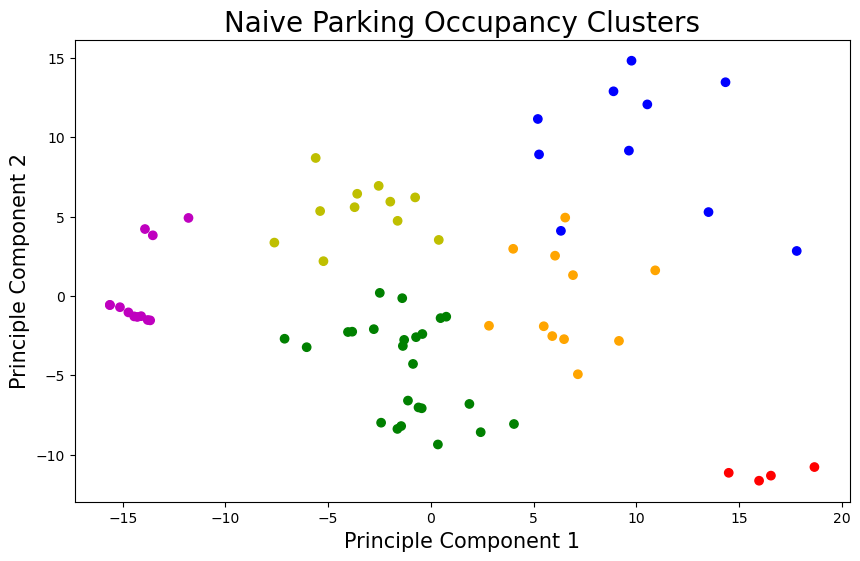

In [75]:
colors = ['b', 'g', 'r', 'm', 'y', 'orange', 'pink', 'black']
color_map = []
for index in clusters:
    color_map.append(colors[index])
plt.figure(figsize=(10,6))
plt.scatter(PCA_2d[:,0], PCA_2d[:,1], color=color_map)
plt.title("Naive Parking Occupancy Clusters", fontsize=20)
plt.ylabel("Principle Component 2", fontsize=15)
plt.xlabel("Principle Component 1", fontsize=15)
plt.show()

 ## Based Case Test

In [76]:
lambda_val = 0.01
gamma = 0.001
rrg = kernel_ridge.KernelRidge(alpha=lambda_val, kernel='rbf', gamma=gamma)

In [77]:
rrg.fit(x_train, y_train)
y_pred = rrg.predict(x_test)
mae = np.mean(np.abs(y_test-y_pred))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.8770932933055254


In [78]:
mae = np.mean(np.abs(y_test-x_test))
print('Base Case Accuracy:', 1-mae)

Base Case Accuracy: 0.599599074074074


## Q-Learning

In [79]:
train_data = [copy.deepcopy(x_bins), copy.deepcopy(y_bins)]
test_data = [copy.deepcopy(x_test), copy.deepcopy(y_test)]
max_bins = [len(x_bins[i]) for i in range(n_clusters)]
print('max bins:', max_bins)

max bins: [10, 24, 4, 12, 11, 11]


In [80]:
model = mdp.BanditMDP(train_data, test_data, max_bins, lambda_val, gamma)
samples = 24
model.set_goal(samples)

In [81]:
# Need about 10000000 iterations to converge
n_iteration = 10000000
for i in tqdm(range(n_iteration)):
    model.run_iteration()

100%|████████████████████████████| 10000000/10000000 [03:12<00:00, 51887.33it/s]


In [82]:
sol = model.get_solution()

curr_state [0, 0, 0, 0, 0, 0]
action: 1
curr_state [1, 0, 0, 0, 0, 0]
action: 1
curr_state [2, 0, 0, 0, 0, 0]
action: 2
curr_state [2, 1, 0, 0, 0, 0]
action: 2
curr_state [2, 2, 0, 0, 0, 0]
action: 2
curr_state [2, 3, 0, 0, 0, 0]
action: 3
curr_state [2, 3, 1, 0, 0, 0]
action: 3
curr_state [2, 3, 2, 0, 0, 0]
action: 3
curr_state [2, 3, 3, 0, 0, 0]
action: 3
curr_state [2, 3, 4, 0, 0, 0]
action: 4
curr_state [2, 3, 4, 1, 0, 0]
action: 4
curr_state [2, 3, 4, 2, 0, 0]
action: 4
curr_state [2, 3, 4, 3, 0, 0]
action: 4
curr_state [2, 3, 4, 4, 0, 0]
action: 4
curr_state [2, 3, 4, 5, 0, 0]
action: 5
curr_state [2, 3, 4, 5, 1, 0]
action: 5
curr_state [2, 3, 4, 5, 2, 0]
action: 5
curr_state [2, 3, 4, 5, 3, 0]
action: 6
curr_state [2, 3, 4, 5, 3, 1]
action: 5
curr_state [2, 3, 4, 5, 4, 1]
action: 6
curr_state [2, 3, 4, 5, 4, 2]
action: 5
curr_state [2, 3, 4, 5, 5, 2]
action: 5
curr_state [2, 3, 4, 5, 6, 2]
action: 6
curr_state [2, 3, 4, 5, 6, 3]
action: 6
Solution State [2, 3, 4, 5, 6, 4]


## RL case

In [83]:
def apply_distribution(x_bins, y_bins, sol_bins):
    x_result = None
    y_result = None
    for i, n in enumerate(sol_bins):
        indices = np.random.choice(len(x_bins[i]), n, replace=False)
        x_bin = np.array(x_bins[i])
        y_bin = np.array(y_bins[i])
        if x_result is None:
            x_result = x_bin[indices]
            y_result = y_bin[indices]
        else:
            x_result = np.concatenate((x_result, x_bin[indices]))
            y_result = np.concatenate((y_result, y_bin[indices]))
            
    return x_result, y_result       

In [84]:
mae_arr = []
for i in range(1000):
    rlx_train, rly_train = apply_distribution(x_bins, y_bins, sol)
    rrg.fit(rlx_train, rly_train)
    y_pred = rrg.predict(x_test)
    mae = np.mean(np.abs(y_test-y_pred))
    mae_arr.append(1-mae)
    
print('RL Case Average Accuracy:', np.mean(mae_arr))
print('RL Case Max Accuracy:', np.max(mae_arr))
print('RL Case Min Accuracy:', np.min(mae_arr))

RL Case Average Accuracy: 0.8388729003914526
RL Case Max Accuracy: 0.8968331839236875
RL Case Min Accuracy: 0.7029916284485923
